<a href="https://colab.research.google.com/github/taocao/500lines/blob/master/Speech-Recognition-with-Convolution-Neural-Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition with Convolution Neural Networks

Hello everyone, today we are going to discuss how to build a Neural Network to detect speach words.

We are going to build  a neural network using convolutions.

- Convolutional 


We are going to download several sounds that will be used to create your Machine Learning Model.


# 1. Introduction

The goal of this project is to implement an audio classification system, which: 
1. first reads in an audio clip (containing at most one word),
2. and then recognizes the class(label) of this audio.


### Classes  
10 classes are chosen, namely:   


In [1]:
classes=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

## Step 1 Import the packages

In [2]:
from time import sleep
from tqdm import tqdm
import os
import urllib.request
import pathlib
import shutil
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

## Step 2 Creation of some utility programs

We define some functions that allow us download the datasets that we need to use to create our ML model and train it.

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_file(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(
            url, filename=output_path, reporthook=t.update_to)

## Step 3 We define some parameters

In [4]:
# current working directory
DIR = os.path.abspath(os.getcwd())
DATASET_DIRECTORY_PATH = DIR+'/data/speech_commands'
#DOWNLOAD_URL = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
DOWNLOAD_URL = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"

### Downloading the data and  Unzip the tar file

In [5]:
# Check if dataset directory already exist, otherwise download, extract and remove the archive
if not os.path.isdir(DATASET_DIRECTORY_PATH):
    if not os.path.isdir(DIR+'/data'):
        os.mkdir(DIR+'/data')
    print('Downloading from ' + DOWNLOAD_URL)
    download_file(DOWNLOAD_URL, DIR+'/data/speech_commands.tar.gz')
    print("Extracting archive...")
    shutil.unpack_archive(
        DIR+'/data/speech_commands.tar.gz', DATASET_DIRECTORY_PATH)
    os.remove(DIR+'/data/speech_commands.tar.gz')
    print("Done.")

speech_commands_v0.01.tar.gz: 1.49GB [00:10, 141MB/s]                            


Extracting archive...
Done.


# Delete the extra files of extracted file

In [6]:
# Cleaning data
if os.name == 'nt':
    print("We are on Windows")
    paths=DIR+'\data\speech_commands'
    os.chdir(paths)
    files=['testing_list.txt','validation_list.txt','LICENSE','README.md']
    for f in files:
        try:
            os.remove(f)
        except FileNotFoundError:
            continue
    #!dir
    os.chdir(DIR)
else:
    print("We are on Unix")
    extras=DIR+'/data/speech_commands/*.*'
    command='rm -rf '+ extras
    os.system(command)
    extras=DIR+'/data/speech_commands/LICENSE'
    command='rm -rf '+ extras
    os.system(command)
    #!ls ./data/speech_commands

We are on Unix


In [7]:
train_audio_path =DATASET_DIRECTORY_PATH+"/"

In [8]:
# Number of recording of each voices
labels = os.listdir(train_audio_path)
print(labels)

['six', 'no', 'one', 'zero', 'bird', 'house', 'two', 'dog', 'yes', 'happy', 'right', 'down', 'seven', 'stop', 'four', 'cat', 'five', 'left', 'off', 'nine', 'sheila', 'tree', 'go', 'marvin', 'wow', 'three', 'bed', 'on', '_background_noise_', 'up', 'eight']


In [9]:
to_remove = [x for x in labels if x not in classes]

In [10]:
print(to_remove)

['six', 'one', 'zero', 'bird', 'house', 'two', 'dog', 'happy', 'seven', 'four', 'cat', 'five', 'nine', 'sheila', 'tree', 'marvin', 'wow', 'three', 'bed', '_background_noise_', 'eight']


In [11]:
for directory in to_remove:
    noise_dir_new=DIR+'/data/'+directory
    noise_dir_old=DIR+'/data/speech_commands/'+directory
    try:
        shutil.move(noise_dir_old, noise_dir_new)
    except FileNotFoundError as e:
        pass  #folder doesn't exist, deal with it.

In [12]:
# Number of recording of each voices
labels = os.listdir(train_audio_path)
print(labels)

['no', 'yes', 'right', 'down', 'stop', 'left', 'off', 'go', 'on', 'up']


# Data Exploration and Visualization

In [13]:
train_audio_path =DATASET_DIRECTORY_PATH+"/"

In [14]:
#Load the audio file
samples,sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav',sr = 16000)

In [15]:
#Sampling Rate
ipd.Audio(samples, rate=sample_rate)

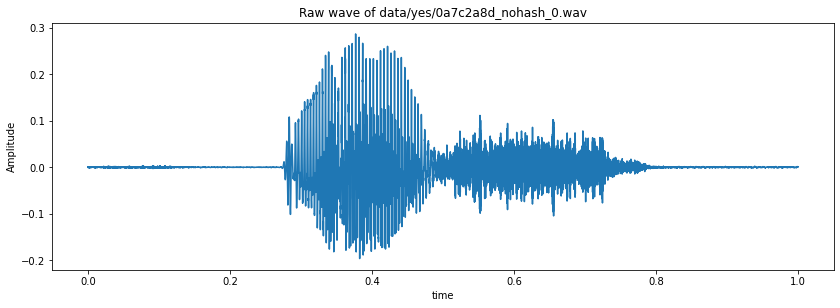

In [16]:
#Visualizing the audio - waveform
fig = plt.figure(figsize = (14,10))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'data/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [17]:
#Visualizing the audio - waveform
import matplotlib.pyplot as plt
import librosa.display

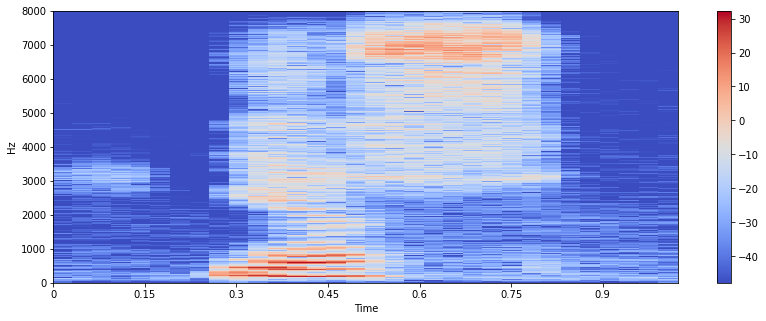

In [18]:
#Spectogram
samples_X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(samples_X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

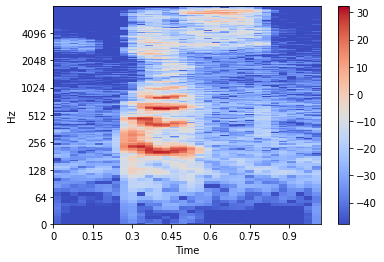

In [19]:
#Interchange the axis
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

# Sampling rate

In [20]:
ipd.Audio(samples,rate = sample_rate)
print(sample_rate)

16000


# Resampling

In [21]:
samples = librosa.resample(samples,sample_rate,8000)
ipd.Audio(samples,rate = 8000)

# Number of recording of each voices

In [22]:
labels = os.listdir(train_audio_path)
labels

['no', 'yes', 'right', 'down', 'stop', 'left', 'off', 'go', 'on', 'up']

In [23]:
from matplotlib import cm

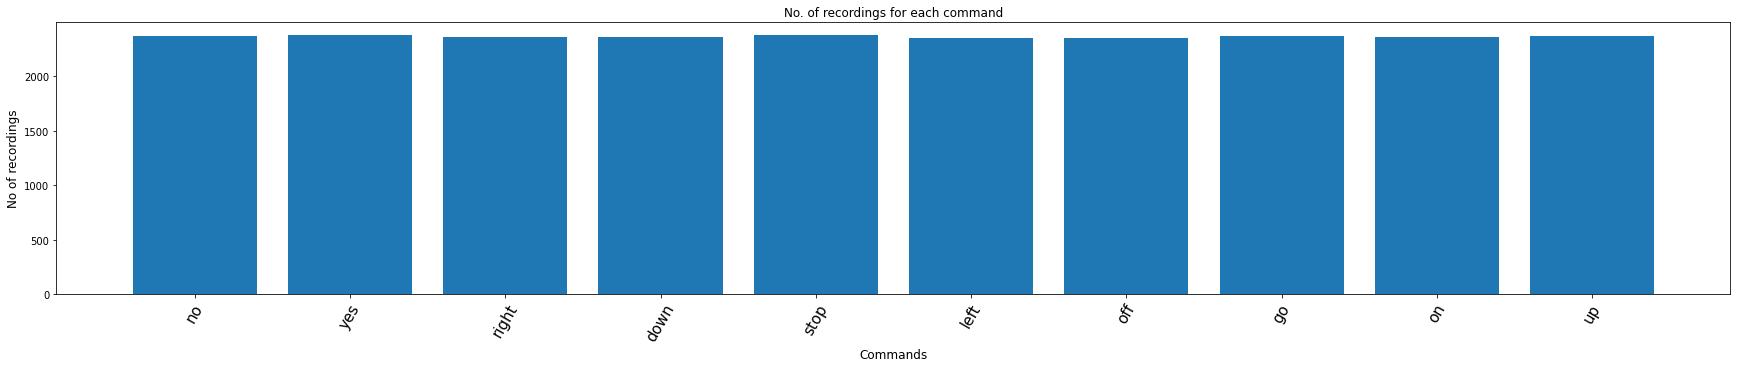

In [24]:
labels=os.listdir(train_audio_path)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


# Duration of recordings

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

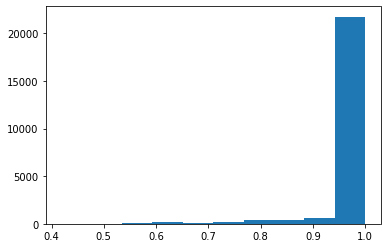

In [25]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

# Preprocessing the audio waves

In [26]:
from tqdm.notebook import tqdm # Notebook
#from tqdm import tqdm # Python

In [27]:
train_audio_path =DATASET_DIRECTORY_PATH+"/"
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    #waves=waves[:20] # The first 20
    for wav in tqdm(waves):
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes


  0%|          | 0/2377 [00:00<?, ?it/s]

no


  0%|          | 0/2375 [00:00<?, ?it/s]

up


  0%|          | 0/2375 [00:00<?, ?it/s]

down


  0%|          | 0/2359 [00:00<?, ?it/s]

left


  0%|          | 0/2353 [00:00<?, ?it/s]

right


  0%|          | 0/2367 [00:00<?, ?it/s]

on


  0%|          | 0/2367 [00:00<?, ?it/s]

off


  0%|          | 0/2357 [00:00<?, ?it/s]

stop


  0%|          | 0/2380 [00:00<?, ?it/s]

go


  0%|          | 0/2372 [00:00<?, ?it/s]

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [29]:
len(all_wave)

21312

In [30]:
len(y)

21312

In [31]:
from keras.utils import np_utils
y = np_utils.to_categorical(y,num_classes = len(labels))
all_waves = np.array(all_wave).reshape(-1,8000,1)

# Split into train and validation set

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
#Extract training, test and validation datasets
#Split twice to get the validation set
x_tr, X_test, y_tr, y_test = train_test_split(np.array(all_wave), np.array(y), test_size=0.2, random_state=7, stratify=y)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.2, random_state=7)
#Print the shapes
x_tr.shape, X_test.shape, x_val.shape, len(y_tr), len(y_test), len(y_val)

((13639, 8000), (4263, 8000), (3410, 8000), 13639, 4263, 3410)

# Analisis of the Shape 

In [34]:
#Print the shapes
x_tr.shape, y_tr.shape, len(y_tr)

((13639, 8000), (13639, 10), 13639)

In [35]:
index_col= 3 #index_of_column_you_need
print(y_tr[:,index_col])

[0. 0. 0. ... 0. 0. 0.]


In [36]:
print(len(y_tr[:,3]))

13639


# First Model - Conv Model for Speach Recognition

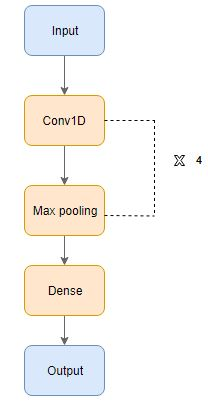

In [37]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [38]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [39]:
es = EarlyStopping(monitor = 'val_loss',mode = 'min',verbose = 1,patience = 10,min_delta = 0.0001)
mc = ModelCheckpoint('best_model.hdf5',monitor = 'val_acc',verbose = 1,save_best_only = True,mode = 'max')

In [40]:
history = model.fit(
    x_tr,
    y_tr,
    epochs = 100,
    callbacks=[es,mc],
    batch_size =32,
    validation_data = (x_val,y_val))

Epoch 1/100
427/427 [==============================] - ETA: 0s - loss: 2.1845 - accuracy: 0.1701

427/427 [==============================] - 16s 9ms/step - loss: 2.1845 - accuracy: 0.1701 - val_loss: 2.2205 - val_accuracy: 0.1680
Epoch 2/100
421/427 [============================>.] - ETA: 0s - loss: 1.8098 - accuracy: 0.3238

427/427 [==============================] - 4s 9ms/step - loss: 1.8075 - accuracy: 0.3242 - val_loss: 1.7254 - val_accuracy: 0.3513
Epoch 3/100
424/427 [============================>.] - ETA: 0s - loss: 1.3876 - accuracy: 0.4767

427/427 [==============================] - 3s 8ms/step - loss: 1.3861 - accuracy: 0.4772 - val_loss: 1.0865 - val_accuracy: 0.6284
Epoch 4/100
425/427 [============================>.] - ETA: 0s - loss: 1.1266 - accuracy: 0.5967

427/427 [==============================] - 3s 8ms/step - loss: 1.1265 - accuracy: 0.5966 - val_loss: 0.9517 - val_accuracy: 0.6836
Epoch 5/100
427/427 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.6550

427/427 [==============================] - 4s 9ms/step - loss: 0.9844 - accuracy: 0.6550 - val_loss: 0.8982 - val_accuracy: 0.6933
Epoch 6/100
426/427 [============================>.] - ETA: 0s - loss: 0.8668 - accuracy: 0.6931

427/427 [==============================] - 4s 9ms/step - loss: 0.8667 - accuracy: 0.6932 - val_loss: 0.7524 - val_accuracy: 0.7419
Epoch 7/100
424/427 [============================>.] - ETA: 0s - loss: 0.8111 - accuracy: 0.7092

427/427 [==============================] - 4s 9ms/step - loss: 0.8119 - accuracy: 0.7088 - val_loss: 0.7453 - val_accuracy: 0.7455
Epoch 8/100
427/427 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.7301

427/427 [==============================] - 3s 8ms/step - loss: 0.7628 - accuracy: 0.7301 - val_loss: 0.6533 - val_accuracy: 0.7780
Epoch 9/100
423/427 [============================>.] - ETA: 0s - loss: 0.7233 - accuracy: 0.7452

427/427 [==============================] - 4s 9ms/step - loss: 0.7218 - accuracy: 0.7457 - val_loss: 0.6951 - val_accuracy: 0.7695
Epoch 10/100
421/427 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.7645

427/427 [==============================] - 4s 9ms/step - loss: 0.6713 - accuracy: 0.7644 - val_loss: 0.6259 - val_accuracy: 0.7991
Epoch 11/100
423/427 [============================>.] - ETA: 0s - loss: 0.6365 - accuracy: 0.7733

427/427 [==============================] - 3s 8ms/step - loss: 0.6372 - accuracy: 0.7733 - val_loss: 0.5625 - val_accuracy: 0.8179
Epoch 12/100
423/427 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7818

427/427 [==============================] - 4s 9ms/step - loss: 0.6225 - accuracy: 0.7819 - val_loss: 0.5838 - val_accuracy: 0.8111
Epoch 13/100
424/427 [============================>.] - ETA: 0s - loss: 0.5869 - accuracy: 0.7946

427/427 [==============================] - 4s 9ms/step - loss: 0.5875 - accuracy: 0.7943 - val_loss: 0.5418 - val_accuracy: 0.8229
Epoch 14/100
420/427 [============================>.] - ETA: 0s - loss: 0.5586 - accuracy: 0.8053

427/427 [==============================] - 4s 9ms/step - loss: 0.5581 - accuracy: 0.8056 - val_loss: 0.5649 - val_accuracy: 0.8208
Epoch 15/100
421/427 [============================>.] - ETA: 0s - loss: 0.5390 - accuracy: 0.8101

427/427 [==============================] - 4s 9ms/step - loss: 0.5383 - accuracy: 0.8106 - val_loss: 0.5619 - val_accuracy: 0.8170
Epoch 16/100
426/427 [============================>.] - ETA: 0s - loss: 0.5308 - accuracy: 0.8160

427/427 [==============================] - 4s 8ms/step - loss: 0.5307 - accuracy: 0.8160 - val_loss: 0.5227 - val_accuracy: 0.8199
Epoch 17/100
424/427 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.8270

427/427 [==============================] - 4s 8ms/step - loss: 0.4969 - accuracy: 0.8265 - val_loss: 0.5145 - val_accuracy: 0.8311
Epoch 18/100
424/427 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.8345

427/427 [==============================] - 4s 8ms/step - loss: 0.4804 - accuracy: 0.8345 - val_loss: 0.5231 - val_accuracy: 0.8214
Epoch 19/100
424/427 [============================>.] - ETA: 0s - loss: 0.4750 - accuracy: 0.8385

427/427 [==============================] - 4s 9ms/step - loss: 0.4757 - accuracy: 0.8386 - val_loss: 0.5066 - val_accuracy: 0.8308
Epoch 20/100
423/427 [============================>.] - ETA: 0s - loss: 0.4528 - accuracy: 0.8444

427/427 [==============================] - 4s 8ms/step - loss: 0.4518 - accuracy: 0.8449 - val_loss: 0.4993 - val_accuracy: 0.8378
Epoch 21/100
421/427 [============================>.] - ETA: 0s - loss: 0.4486 - accuracy: 0.8455

427/427 [==============================] - 4s 9ms/step - loss: 0.4486 - accuracy: 0.8457 - val_loss: 0.4709 - val_accuracy: 0.8457
Epoch 22/100
421/427 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8477

427/427 [==============================] - 4s 9ms/step - loss: 0.4314 - accuracy: 0.8476 - val_loss: 0.5031 - val_accuracy: 0.8408
Epoch 23/100
424/427 [============================>.] - ETA: 0s - loss: 0.4192 - accuracy: 0.8550

427/427 [==============================] - 4s 9ms/step - loss: 0.4199 - accuracy: 0.8548 - val_loss: 0.5187 - val_accuracy: 0.8282
Epoch 24/100
421/427 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8568

427/427 [==============================] - 4s 8ms/step - loss: 0.4061 - accuracy: 0.8568 - val_loss: 0.4886 - val_accuracy: 0.8381
Epoch 25/100
426/427 [============================>.] - ETA: 0s - loss: 0.3981 - accuracy: 0.8630

427/427 [==============================] - 4s 9ms/step - loss: 0.3981 - accuracy: 0.8630 - val_loss: 0.4847 - val_accuracy: 0.8428
Epoch 26/100
422/427 [============================>.] - ETA: 0s - loss: 0.3973 - accuracy: 0.8643

427/427 [==============================] - 4s 9ms/step - loss: 0.3969 - accuracy: 0.8644 - val_loss: 0.4789 - val_accuracy: 0.8440
Epoch 27/100
420/427 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8687

427/427 [==============================] - 4s 8ms/step - loss: 0.3681 - accuracy: 0.8688 - val_loss: 0.4882 - val_accuracy: 0.8446
Epoch 28/100
421/427 [============================>.] - ETA: 0s - loss: 0.3619 - accuracy: 0.8739

427/427 [==============================] - 4s 9ms/step - loss: 0.3619 - accuracy: 0.8737 - val_loss: 0.4851 - val_accuracy: 0.8434
Epoch 29/100
426/427 [============================>.] - ETA: 0s - loss: 0.3763 - accuracy: 0.8700

427/427 [==============================] - 4s 8ms/step - loss: 0.3762 - accuracy: 0.8700 - val_loss: 0.5462 - val_accuracy: 0.8279
Epoch 30/100
421/427 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8786

427/427 [==============================] - 4s 8ms/step - loss: 0.3420 - accuracy: 0.8789 - val_loss: 0.4881 - val_accuracy: 0.8469
Epoch 31/100
422/427 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8802

427/427 [==============================] - 4s 8ms/step - loss: 0.3439 - accuracy: 0.8798 - val_loss: 0.5033 - val_accuracy: 0.8387
Epoch 31: early stopping


In [41]:
model.save("best_model.hdf5")

# Diagnostic plot


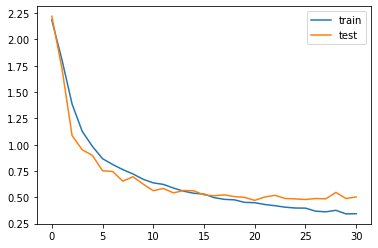

In [42]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.savefig("plot.jpg")
pyplot.show()

In [43]:
n_epochs = len(history.history['loss'])

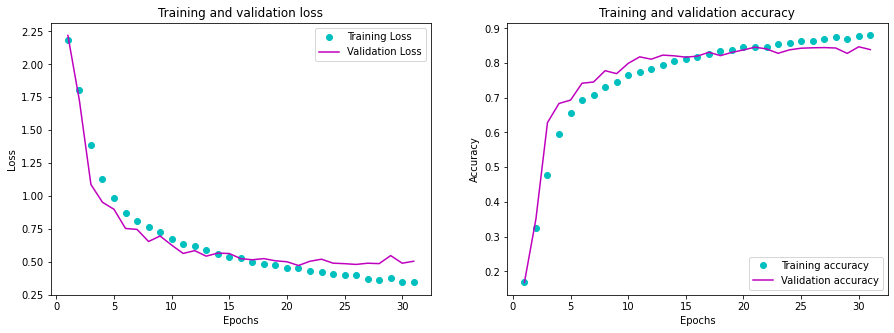

In [44]:
early_epoch=n_epochs
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,early_epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# Loading the best model

In [45]:
from keras.models import load_model
model=load_model('best_model.hdf5')
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [46]:
import random
index=random.randint(0,len(x_val)-1)
print(index)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

283
Audio: off
Text: off


In [47]:
y_true_label = []
for  index in range(len(x_val)-1):
        y_true_label.append(classes[np.argmax(y_val[index])]) 

In [48]:
#y_true_label

In [49]:
y_true = []
for  index in range(len(x_val)-1):
        y_true.append(np.argmax(y_val[index])) 

In [50]:
#y_true

In [51]:
test_labels = []
for  index in range(len(x_val)-1):
        test_labels.append(x_val[index].ravel()) 

In [52]:
#test_labels 

In [53]:
y_pred_label = []
for i in test_labels:
    prediction=predict(i)
    y_pred_label.append(prediction)

In [54]:
#y_pred_label

In [55]:
y_pred = []
for audio in test_labels:
    prob=model.predict(audio.reshape(1,8000,1))
    prediction=np.argmax(prob[0])
    y_pred.append(prediction)

In [56]:
#y_pred

In [57]:
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.87%


# Predictions on the validation data:

In [58]:
import tensorflow as tf
import seaborn as sns

In [59]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

Text(69.0, 0.5, 'Label')

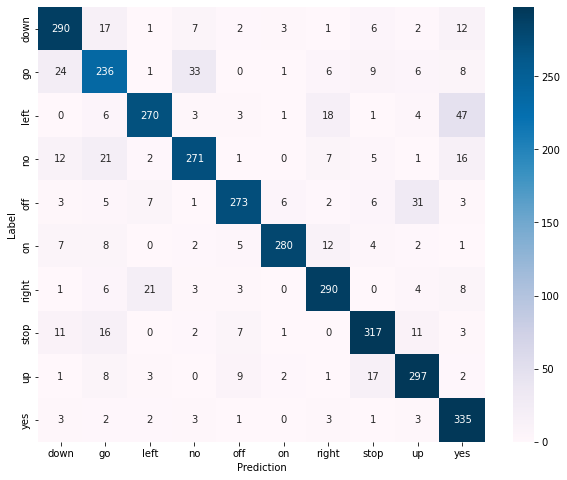

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, cmap="PuBu", robust=True,
            xticklabels=classes, yticklabels=classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
#plt.savefig(_PATH_TO_RESULTS+'/images/confusion_matrix.png')